# 房价预测

## 下载数据集

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests


#@save
#创建一个字典，里面的数据都以一个二元组存储，包含数据集的url和验证文件完整性的sha-1密钥
DATA_HUB = dict()
#所有类似的数据集都托管在地址为DATA_URL的站点上
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

#download函数用来下载数据集
#将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 
#缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)#每次读取1048576个字节，也就是1M
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


#一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 下载kaggle数据集

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

#使用pandas读取数据，我们使用pandas分别加载包含训练数据和测试数据的两个CSV文件。
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

#训练数据集包括1460个样本，每个样本80个特征和1个标签， 而测试数据集包含1459个样本，每个样本80个特征。
print(train_data.shape)
print(test_data.shape)

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data\kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)


## 查看数据长什么样

In [5]:
#查看前面4行，查看前4个特征和后两个特征和标签
#数据里面有文本，有特征
#iloc通过索引的具体值来取数据
#最后一个数据就是标签，房价
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [14]:
#我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 
#因此，在将数据提供给模型之前，我们将其从数据集中删除。
#pd.concat是将训练集和测试集拼接在一起
#train_data.iloc[:,1:-1]是去掉训练集的ID和label，选择1：-1之间的数据，也就是不包括ID和label
#test_data.iloc[:,1:]是去掉测试集的ID
#这里需要两个括号，少一个括号就会报错
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape

(2919, 79)

In [19]:
#将所有缺失值替换为相应特征的平均值。
#所有非文本的数值作归一化
#找到非文本数据的所有下标
numeric_features=all_features.dtypes[all_features.dtypes !='object'].index
#所有非文本的数值作归一化
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/x.std())
#将所有缺失值替换为相应特征的平均值。
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [21]:
#文本数据做one-hot编码
## “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [31]:
#从pandas格式中通过values属性提取NumPy格式，并将其转换为张量表示用于训练。
#因为tensor是专门为GPU加速设计的矩阵，而numpy却不行。其实就相当于一个为GPU设计的数据结构。
#numpy是64位的
#all_features[:n_train].values第一维的数据提取为一个numpy数组
n_train=train_data.shape[0] #1460
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)
train_labels.shape,train_features.shape,test_features.shape

(torch.Size([1460, 1]), torch.Size([1460, 331]), torch.Size([1459, 331]))

## 训练

In [26]:
loss=nn.MSELoss()
in_features=train_data.shape[1]

def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    return

## 损失函数采用均方根误差

#如果采用均方误差，那房价比较高的有可能差值比较大，我们更关系相对误差(y-y^)/y，因为涉及到除法，我们取对数
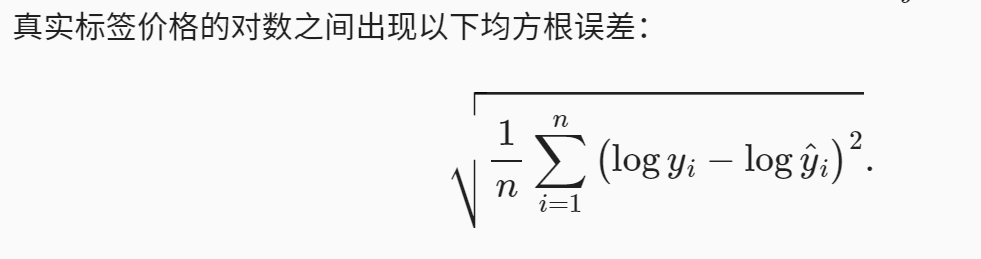

In [27]:
def log_rmse(net,features,labels):
    #torch.clamp()是将输入限制在一个区间范围内
     # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [28]:
#训练函数借助Adam优化器，对学习率没有那么敏感
def train(net, train_features, train_labels, test_features, test_labels,num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [32]:
#在K折交叉验证过程中返回第i折的数据。 返回了训练集和验证集，x和y分别代表数据和标签。
#具体地说，它选择第个切片作为验证数据，其余部分作为训练数据。
def get_k_fold_data(k, i, X, y):
    assert k > 1
    #每一折的大小
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        #一折的下标
        idx = slice(j * fold_size, (j + 1) * fold_size)
        #数据和标签，标签只有1个特征
        X_part, y_part = X[idx, :], y[idx]
        #是当前折，就作为验证集
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
#返回训练和验证的平均值
